## Notebook Information

**Master in Quantum Computing - UNIR**

**Subject:** Quantum Computing

**Notebook Activity by:** Albert Nieto Morales

**Date:** 2024-02-05

---

*Note: This notebook is part of the Master's program in Quantum Computing at UNIR. The content focuses on Quantum Computing and was created by Albert Nieto. Please refer to the date for the latest update.*


# Laboratorio: Estimación de fase

Aplicar los conocimientos adquiridos para aplicar el algoritmo QPE (Quantum Phase Estimation) y determinar la fase de un operador unitario U. Para ello se utilizará el entorno de desarrollo de QISKit, Quantum Lab.

# Librerías

Primero tenemos que instalar las bibliotecas necesarias para trabajar con Qiskit: las bibliotecas `qiskit`, `qiskit-ibmq-provider` y `qiskit-aer` (el comando mágico `%%capture` suprime la salida de la instalación de paquetes con pip).

1. Qiskit: Librería general.
2. Qiskit-ibmq-provider: Proporciona acceso a los servicios en la nube de IBM Quantum.
3. Qiskit-aer: Ofrece simuladores de alto rendimiento para simular circuitos cuánticos.

In [1]:
%%capture
%pip install qiskit
%pip install qiskit-ibmq-provider
%pip install qiskit-aer

Importa las bibliotecas estándar de Qiskit, así como herramientas de visualización y carga la cuenta de IBM Quantum: `IBMProvider.save_account()` para guardar las credenciales de la cuenta de IBM Quantum.

In [2]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_ibm_provider import IBMProvider

# Other imports
import matplotlib.pyplot as plt
import numpy as np
import math

# Loading your IBM Quantum account(s)
IBMProvider.save_account("", overwrite=True)

# Explicación del QPE

## Definición

### Operador Unitario
El algoritmo de Estimación Cuántica de Fase (QPE) resuelve una tarea sencilla: dado un estado propio de un operador unitario, encontrar su valor propio. 

Tenemos un operador unitario $U$ y uno de sus estados propios $|\psi\rangle$. El operador es unitario, por lo que podemos escribir

$$ U|\psi\rangle = e^{i\phi}|\psi\rangle, $$

donde $\phi$ es la fase del valor propio. El objetivo es estimar $\phi$, de ahí el nombre de estimación de fase. Llamaremos a $\theta$ como la fase.


### Representando la fase

Definimos $\phi = 2\pi\theta$ de modo que:
- $\theta$ sea un número comprendido entre 0 y 1, es decir, una fracción de $2\pi$. 
- $\phi$ esté entre 0 y $2\pi$.

Para poder representar $\theta$ en un ordenador cuántico, lo tenemos que representar en binario: $\theta' = 0.\theta_1\theta_2\theta_3...\theta_n$. Siendo $n$ la precisión deseada. Gracias a esto lo podemos codificar utilizando qubits.

Definimos una función que nos convertirá la fase que queramos a fracción:

In [3]:
def phase_to_fraction(phase):
    """
    Convert a phase angle in radians to a fraction of a full cycle.

    Parameters:
    - phase (float): The phase angle in radians.

    Returns:
    - float: The fraction of the phase angle compared to a full cycle (2π).
    """
    return phase / (math.pi * 2)

Definimos una función que nos convertirá la fracción decimal a fracción binaria:

In [4]:
def fraction_to_binary(fraction: float, precision: int = 10) -> str:
    """
    Convert a fraction to its binary representation.

    1. Multiply br by 2.
    2. If the result is greater than or equal to 1, append '1' to the binary representation and subtract 1 from the result.
    3. If the result is less than 1, append '0' to the binary representation.
    4. Repeat steps 1-3 until you either run out of precision or the result becomes zero.

    Args:
    - fraction (float): The fraction to be converted.
    - precision (int): The number of binary digits after the decimal point. Default is 10.

    Returns:
    - str: The binary representation of the fraction.
    """

    if fraction < 0:
        return "Fraction must be non-negative"

    integer_part = int(fraction)
    fractional_part = fraction - integer_part

    # Convert integer part to binary
    integer_binary = bin(integer_part)[2:]

    # If there's no fractional part, return just the integer binary
    if fractional_part == 0:
        return integer_binary

    binary_frac = "."

    # In binary representation, multiplying by 2 corresponds to shifting all digits one position to the left.
    # This is equivalent to doubling the value in base 10.
    while fractional_part > 0 and precision > 0:
        fractional_part *= 2
        if fractional_part >= 1:
            binary_frac += "1"
            fractional_part -= 1
        else:
            binary_frac += "0"
        precision -= 1

    return integer_binary + binary_frac

Y de fracción binaria a decimal:

In [5]:
def binary_to_fraction(binary_frac: str) -> float:
    """
    Convert a binary fraction to its equivalent decimal fraction.

    Args:
    - binary_frac (str): The binary fraction to be converted.

    Returns:
    - float: The equivalent decimal fraction.
    """
    # Check if the binary fraction is empty
    if not binary_frac:
        return 0.0

    # Check if the binary fraction has no fractional part
    if "." not in binary_frac:
        return int(binary_frac)

    # Split the binary fraction into its decimal and fractional parts
    decimal_part, fractional_part = binary_frac.split(".")

    # Convert the decimal part to decimal value
    decimal_value = int(decimal_part, 2)

    # Convert the fractional part to decimal value
    # Sum the contribution of each bit in the fractional part
    fractional_value = sum(
        int(bit) * 2 ** -(i + 1) for i, bit in enumerate(fractional_part)
    )

    # Combine the decimal and fractional values to get the final decimal fraction
    return float(decimal_value) + fractional_value

Utilizando estas funciones podemos ver cuál es el resultado esperado para $\pi/9$

In [6]:
expected_result = phase_to_fraction(math.pi / 9)
expected_output = fraction_to_binary(expected_result, precision=16)

print(f"Expected result in decimal:\t{expected_result}")
print(f"Expected result in binary:\t{expected_output}")

Expected result in decimal:	0.05555555555555555
Expected result in binary:	0.0000111000111000


# Implementación

El objetivo del ejercicio es estimar, con la suficiente precisión, la fase del operador unitario $U$ que aplica una rotación con respecto al eje $Z$ de $\frac{\pi}{9}$ al estado $|1\rangle$:

$$ U|1\rangle = e^{i\frac{\pi}{9}} |1\rangle $$

Para ello creamos el circuito en una función, para en un futuro crear fácilmente un circuito con cualquier cantidad de qubits y la fase que se requiera.

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT


def QPE(pq, phase):
    """
    Quantum Phase Estimation (QPE) algorithm implementation.

    Parameters:
    - pq (int): The number of precision qubits.
    - phase (float): The phase to be estimated, represented as a fraction of pi.

    Returns:
    - QuantumCircuit: The quantum circuit implementing the QPE algorithm.
    """
    # Initialize the quantum circuit
    qreg = QuantumRegister(pq + 1, "q")
    creg = ClassicalRegister(pq, "ac")
    qc = QuantumCircuit(qreg, creg)

    # Add Hadamart gates to precision qubits
    qc.h(range(pq))

    # Add Pauli-X to the eigenvector qubit
    qc.x(pq)

    # Add controlled U-gates
    repetitions = 1
    for i in range(pq):
        for _ in range(repetitions):
            qc.cp(theta=phase, control_qubit=i, target_qubit=pq)
        repetitions *= 2

    # Add inversed QFT to the precision qubits
    inverse_qft = QFT(num_qubits=pq, inverse=True)
    qc.append(inverse_qft, qargs=qreg[:pq])

    # Measure precision qubits
    qc.measure(qreg[:pq], creg)

    return qc

Para no generar un diagrama del circuito muy extenso, probemos a diseñar un circuito con 3 qubits de precisión:

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


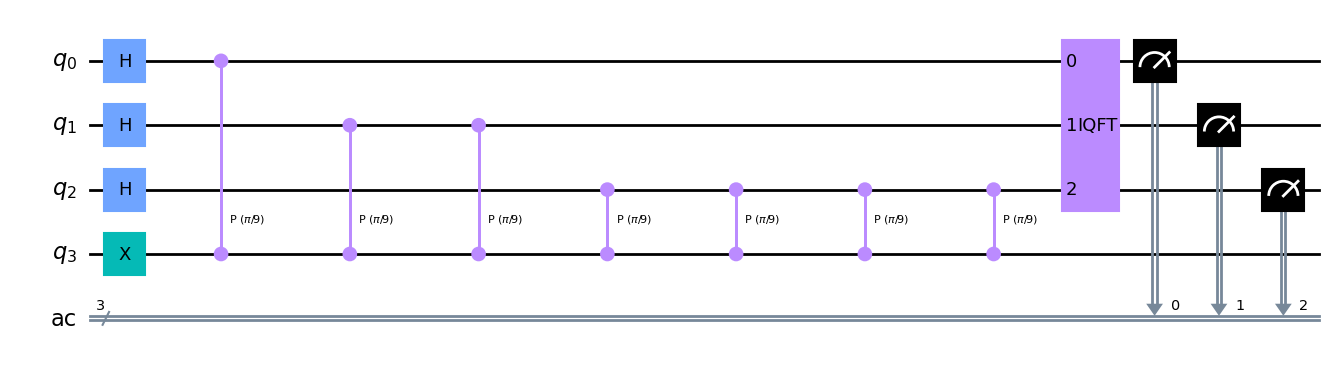

In [8]:
precision_qubits = 3
phase = math.pi / 9

qc = QPE(precision_qubits, phase)
qc.draw("mpl")

# Ejecución del circuito

Diseñemos una función que ejecute el circuito y formatee el resultado en fracción binaria:

In [9]:
from qiskit import Aer, transpile, execute


def run_QPE(qc):
    """
    Execute the Quantum Phase Estimation (QPE) algorithm on a given quantum circuit.

    Parameters:
    - qc (QuantumCircuit): The QPE quantum circuit to execute.

    Returns:
    - dict: A dictionary containing the results of the circuit execution,
            where the keys represent the estimated phases and the values are the
            corresponding observation frequencies.
    """
    # Run the quantum circuit on a aer_simulator simulator backend
    backend = Aer.get_backend("statevector_simulator")

    # Transpile the quantum circuit for the selected backend due to QFT
    qct = transpile(circuits=qc, backend=backend)

    # Execute the quantum circuit and get the results
    result = execute(qct, backend=backend, shots=1000).result()
    counts = result.get_counts(qct)

    # Format the results so that the keys represent the estimated phases
    formated_counts = {f"0.{k}": v for (k, v) in counts.items()}
    return formated_counts

Lo vamos a ejecutar 1000 veces en un simulador y mostramos los datos en un histograma.

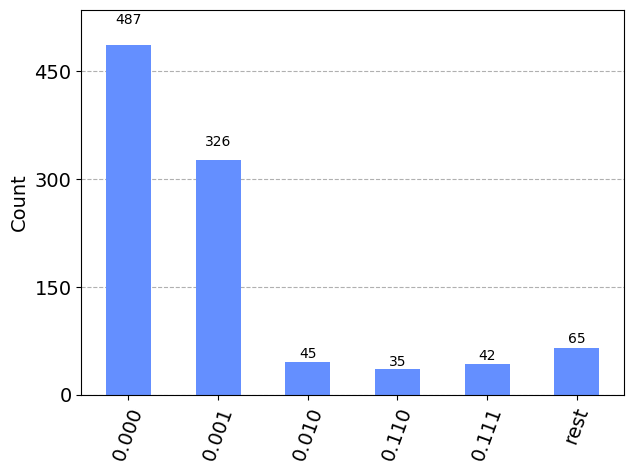

In [10]:
from qiskit.visualization import plot_histogram

result = run_QPE(qc)
plot_histogram(data=result, number_to_keep=5, sort="asc")

Recordemos cuál es el resultado esperado:

In [11]:
expected_result = phase_to_fraction(phase)
expected_output = fraction_to_binary(expected_result, precision=16)

print(f"Expected result in decimal:\t{expected_result}")
print(f"Expected result in binary:\t{expected_output}")

Expected result in decimal:	0.05555555555555555
Expected result in binary:	0.0000111000111000


Para el circuito de prueba de 3 bits de precisión definido anteriormente, vemos que el algoritmo funciona correctamente, estimando con más posibilidad la opción correcta. Vemos que si tuviésemos más qubits de precisión, podríamos conseguir el resultado correcto. 

Evidentemente el resultado no es correcto, porque si tranformamos el valor de binario a decimal nos da 0, pero vemos que si truncamos el resultado esperado con los qubits de precisión, el resultado es correcto.

Utilizando las funciones anteriormente mencionadas, ejecutemos el circuito QPE de 1 a 18 qubits de precision para poder estimar el número óptimo de qubits.

In [12]:
phase = math.pi / 9
precision_qubits = 18
expected_result = phase_to_fraction(phase)
expected_output = fraction_to_binary(expected_result, precision=16)
results = []

# Loop through each number of precision qubit
for i in range(1, precision_qubits + 1):
    qc = QPE(i, phase)
    result = run_QPE(qc)

    # Find the outcome with the highest probability
    highest_outcome, highest_probability = max(result.items(), key=lambda item: item[1])

    # Calculate the percentage of occurrence of the highest outcome
    percentage = int((highest_probability / 1000) * 100)

    # Convert the highest outcome from binary to decimal fraction
    decimal_fraction = binary_to_fraction(highest_outcome)

    # Check if the truncated valid is True (if the expected output matches the highest outcome)
    truncate_valid = expected_output[: i + 2] == highest_outcome

    # Append the results for this iteration to the results list
    results.append(
        [
            i,
            highest_outcome,
            highest_probability / 1000,
            truncate_valid,
            decimal_fraction,
        ]
    )

    print(f"Simulating with {i} qubits done.")

Simulating with 1 qubits done.
Simulating with 2 qubits done.
Simulating with 3 qubits done.
Simulating with 4 qubits done.
Simulating with 5 qubits done.
Simulating with 6 qubits done.
Simulating with 7 qubits done.
Simulating with 8 qubits done.
Simulating with 9 qubits done.
Simulating with 10 qubits done.
Simulating with 11 qubits done.
Simulating with 12 qubits done.
Simulating with 13 qubits done.
Simulating with 14 qubits done.
Simulating with 15 qubits done.
Simulating with 16 qubits done.
Simulating with 17 qubits done.
Simulating with 18 qubits done.


Imprimimos una tabla con los resultados: número de qubits, el resultado con probabilidad más alta, su probabilidad, el resultado en decimal y un booleano que indica que si truncamos el valor esperado con el número de qubits de precision, da lo mismo.

In [13]:
import pandas

headers = [
    "Precision qubits",
    "Output in binary",
    "Probability",
    "Truncate_valid",
    "Output in decimal",
]
df = pandas.DataFrame(data=results, columns=headers)
df = df.style.hide_index()
print(df.to_latex())

C:\Users\Asus\AppData\Local\Temp\ipykernel_25120\3285665193.py:5: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df = df.style.hide_index()


Precision qubits,Output in binary,Probability,Truncate_valid,Output in decimal
1,0.0,0.977000,True,0.000000
2,0.00,0.852000,True,0.000000
3,0.000,0.496000,True,0.000000
4,0.0001,0.970000,False,0.062500
5,0.00010,0.839000,False,0.062500
6,0.000100,0.518000,False,0.062500
7,0.0000111,0.954000,True,0.054688
8,0.00001110,0.846000,True,0.054688
9,0.000011100,0.472000,True,0.054688
10,0.0000111001,0.965000,False,0.055664


Si tenemos en cuenta el resultado pasado a decimal, el resultado óptimo sería con 7 o 10 qubits de precisión. A partir de 16 qubits de precisión, obtenemos el resultado de manera muy precisa.

Vemos que hay algunos resultados que son perfectamente precisos en representación binaria, pero hay algunos que, aunque recoge la periodicidad, se equivoca en los últimos bits.  Los que están correctos, los marcaremos con un círculo y los erróneos con una X. Veamos estos datos en una gráfica. 

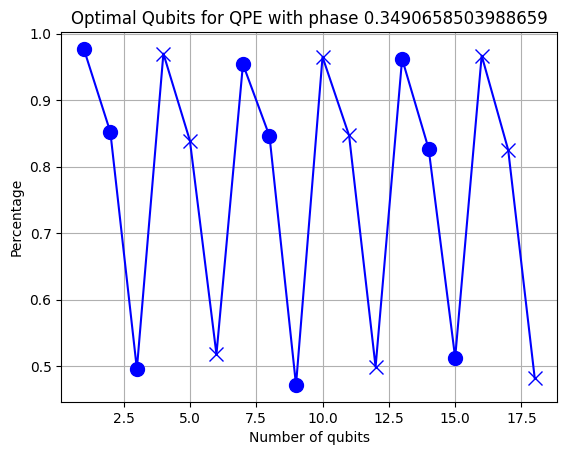

In [14]:
import matplotlib.pyplot as plt

# Initialize lists to store data for lines
x_values = []
y_values = []

for n_qubits, output, percentage, expected, _ in results:
    if expected:
        plt.plot(
            n_qubits, percentage, "o", color="blue", markersize=10
        )  # True: plot a circle
    else:
        plt.plot(
            n_qubits, percentage, "x", color="blue", markersize=10
        )  # False: plot a cross

    x_values.append(n_qubits)
    y_values.append(percentage)

# Plot lines
plt.plot(x_values, y_values, linestyle="-", color="blue")  # Draw lines between points

# Add labels and title
plt.xlabel("Number of qubits")
plt.ylabel("Percentage")
plt.title(f"Optimal Qubits for QPE with phase {phase}")

# Show the plot
plt.grid(True)
plt.show()

Claramente vemos un patrón en los resultados. Tanto en la probabilidad de que el resultado sea correcto, como en la precisión del resultado. Además existe una ligera tendencia a que la probabilidad baje al aumentar los qubits, aunque se tendría que probar con más qubits para confirmar esta tendencia. Debido al inmenso tiempo que tardan las ejecuciones a partir de 16 qubits, he limitado la comparativa a 18 qubits.


Según la precisión que quisiéramos en nuestro resultado, el número de qubits más óptimo sería 1, 7 y 13 qubits. Si el patrón siguiera, el número de qubits óptimos para la precisión requerida sería: 
$$1 + (n - 1) \times 6$$ 
o si no nos importa que haya algún bit incorrecto:
$$1 + (n - 1) \times 3$$

# Extensión de la comprobación
Probemos que esta tendencia existe también para otras fases, por ejemplo $\pi/15$

In [15]:
phase = math.pi / 15

El resultado esperado sería:

In [16]:
expected_result = phase_to_fraction(phase)
expected_output = fraction_to_binary(expected_result, precision=16)

print(f"Expected result in decimal:\t{expected_result}")
print(f"Expected result in binary:\t{expected_output}")

Expected result in decimal:	0.03333333333333333
Expected result in binary:	0.0000100010001000


Ejecutamos el mismo número de veces el circuito para esta fase:

In [17]:
precision_qubits = 16
expected_result = phase_to_fraction(phase)
expected_output = fraction_to_binary(expected_result, precision=16)
results = []

# Loop through each number of precision qubit
for i in range(1, precision_qubits + 1):
    qc = QPE(i, phase)
    result = run_QPE(qc)

    # Find the outcome with the highest probability
    highest_outcome, highest_probability = max(result.items(), key=lambda item: item[1])

    # Calculate the percentage of occurrence of the highest outcome
    percentage = int((highest_probability / 1000) * 100)

    # Convert the highest outcome from binary to decimal fraction
    decimal_fraction = binary_to_fraction(highest_outcome)

    # Check if the truncated valid is True (if the expected output matches the highest outcome)
    truncate_valid = expected_output[: i + 2] == highest_outcome

    # Append the results for this iteration to the results list
    results.append(
        [
            i,
            highest_outcome,
            highest_probability / 1000,
            truncate_valid,
            decimal_fraction,
        ]
    )

    print(f"Simulating with {i} qubits done.")

Simulating with 1 qubits done.
Simulating with 2 qubits done.
Simulating with 3 qubits done.
Simulating with 4 qubits done.
Simulating with 5 qubits done.
Simulating with 6 qubits done.
Simulating with 7 qubits done.
Simulating with 8 qubits done.
Simulating with 9 qubits done.
Simulating with 10 qubits done.
Simulating with 11 qubits done.
Simulating with 12 qubits done.
Simulating with 13 qubits done.
Simulating with 14 qubits done.
Simulating with 15 qubits done.
Simulating with 16 qubits done.


Imprimimos los resultados:

In [18]:
headers = [
    "Precision qubits",
    "Output in binary",
    "Probability",
    "Truncate_valid",
    "Output in decimal",
]
df = pandas.DataFrame(data=results, columns=headers)
df = df.style.hide_index()
df

C:\Users\Asus\AppData\Local\Temp\ipykernel_25120\70045175.py:3: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  df = df.style.hide_index()


Precision qubits,Output in binary,Probability,Truncate_valid,Output in decimal
1,0.0,0.990000,True,0.000000
2,0.00,0.943000,True,0.000000
3,0.000,0.787000,True,0.000000
4,0.0001,0.463000,False,0.062500
5,0.00001,0.982000,True,0.031250
6,0.000010,0.953000,True,0.031250
7,0.0000100,0.799000,True,0.031250
8,0.00001001,0.452000,False,0.035156
9,0.000010001,0.988000,True,0.033203
10,0.0000100010,0.940000,True,0.033203


E imprimimos la gráfica

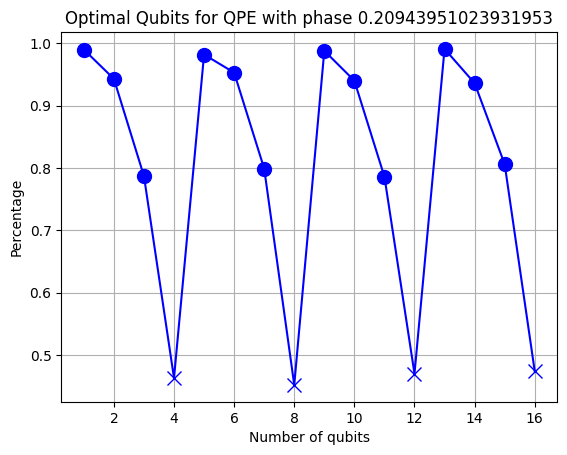

In [19]:
import matplotlib.pyplot as plt

expected_result = phase_to_fraction(phase)
expected_output = fraction_to_binary(expected_result, precision=16)

# Initialize lists to store data for lines
x_values = []
y_values = []

for n_qubits, output, percentage, expected, _ in results:
    if expected:
        plt.plot(
            n_qubits, percentage, "o", color="blue", markersize=10
        )  # True: plot a circle
    else:
        plt.plot(
            n_qubits, percentage, "x", color="blue", markersize=10
        )  # False: plot a cross

    x_values.append(n_qubits)
    y_values.append(percentage)

# Plot lines
plt.plot(x_values, y_values, linestyle="-", color="blue")  # Draw lines between points

# Add labels and title
plt.xlabel("Number of qubits")
plt.ylabel("Percentage")
plt.title(f"Optimal Qubits for QPE with phase {phase}")

# Show the plot
plt.grid(True)
plt.show()

Para este caso vemos que existe un patrón y está relacionado con la longitud del periodo de la fracción binaria. Además, tiende a fallar la precisión cuando $n+1$ es el bit 1. 

Para líneas futuras y para poder confirmar estas suposiciones, se tendría que simular con más bits y diferentes fases.